<a href="https://colab.research.google.com/github/issaAbdu/Degtal/blob/main/Copy_of_Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install pandas networkx matplotlib seaborn python-louvain pyvis scikit-learn

In [ ]:

# الخطوة 1: استيراد المكتبات اللازمة
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from community import community_louvain
from sklearn.preprocessing import MinMaxScaler
from pyvis.network import Network
from google.colab import files
import matplotlib.colors as mcolors
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

<div class="markdown-google-sans">

## **Getting started**
</div>

The document you are reading is not a static web page, but an interactive environment called a **Colab notebook** that lets you write and execute code.

For example, here is a **code cell** with a short Python script that computes a value, stores it in a variable, and prints the result:

In [ ]:

# إنشاء بيانات القنوات (15 قناة رياضية عربية)
channels_data = {
    'channel_id': [f'UC{i:02d}XYZ' for i in range(1, 16)],
    'channel_name': [
        'القناة الرياضية السعودية', 'بي إن سبورتس العربية', 'الكأس الرياضية',
        'يورو سبورت العربية', 'أبو ظبي الرياضية', 'دبي الرياضية',
        'الكويت الرياضية', 'الجزيرة الرياضية', 'المغرب الرياضية',
        'تونس الرياضية', 'العراق الرياضية', 'مصر الرياضية',
        'الجزائر الرياضية', 'عمان الرياضية', 'سوريا الرياضية'
    ],
    'country': [
        'السعودية', 'قطر', 'السعودية', 'الإمارات', 'الإمارات',
        'الإمارات', 'الكويت', 'قطر', 'المغرب', 'تونس',
        'العراق', 'مصر', 'الجزائر', 'عمان', 'سوريا'
    ],
    'subscribers': np.random.randint(50000, 2000000, 15),
    'avg_views': np.random.randint(50000, 1000000, 15),
    'estimated_earnings': np.random.randint(1000, 50000, 15)
}

channels_df = pd.DataFrame(channels_data)

# إنشاء بيانات الفيديوهات والعلاقات
relations = []
for i in range(1, 16):
    for j in range(20):  # 20 فيديو لكل قناة
        source = f'UC{i:02d}XYZ'
        # اختيار 1-3 قنوات للإشارة إليها بشكل عشوائي
        targets = np.random.choice(
            [cid for cid in channels_df['channel_id'] if cid != source],
            size=np.random.randint(1, 4),
            replace=False
        )
        for target in targets:
            relations.append({
                'source': source,
                'target': target,
                'weight': np.random.randint(1, 5)  # قوة العلاقة
            })

relations_df = pd.DataFrame(relations)

# إنشاء بيانات الأداء من Socialblade
socialblade_df = channels_df[['channel_id', 'subscribers', 'avg_views', 'estimated_earnings']].copy()
socialblade_df['growth_rate'] = np.random.uniform(0.5, 5.0, 15)

# حفظ البيانات في ملفات (للمحاكاة)
channels_df.to_csv('channels_data.csv', index=False)
relations_df.to_csv('relations_data.csv', index=False)
socialblade_df.to_csv('socialblade_data.csv', index=False)

print("تم إنشاء البيانات النموذجية بنجاح!")
print(f"عدد القنوات: {len(channels_df)}")
print(f"عدد العلاقات: {len(relations_df)}")

تم إنشاء البيانات النموذجية بنجاح!
عدد القنوات: 15
عدد العلاقات: 605


To execute the code in the above cell, select it with a click and then either press the play button to the left of the code, or use the keyboard shortcut "Command/Ctrl+Enter". To edit the code, just click the cell and start editing.

Variables that you define in one cell can later be used in other cells:

In [ ]:

# إنشاء الرسم البياني للشبكة
G = nx.from_pandas_edgelist(relations_df,
                            source='source',
                            target='target',
                            edge_attr='weight',
                            create_using=nx.Graph())

# إضافة العقد المتبقية (القنوات بدون علاقات)
for channel_id in channels_df['channel_id']:
    if channel_id not in G:
        G.add_node(channel_id)

# إضافة خصائص القنوات إلى الشبكة
for _, row in channels_df.iterrows():
    if row['channel_id'] in G:
        G.nodes[row['channel_id']]['channel_name'] = row['channel_name']
        G.nodes[row['channel_id']]['country'] = row['country']
        G.nodes[row['channel_id']]['subscribers'] = row['subscribers']

print("\n📊 معلومات الشبكة:")
print(f"- عدد العقد (القنوات): {G.number_of_nodes()}")
print(f"- عدد الحواف (العلاقات): {G.number_of_edges()}")
print(f"- الكثافة: {nx.density(G):.4f} (كلما اقتربت من 1 زاد الترابط)")

# حساب مؤشرات المركزية
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

# إضافة المؤشرات إلى بيانات القنوات
centrality_df = pd.DataFrame({
    'channel_id': list(degree_centrality.keys()),
    'degree': list(degree_centrality.values()),
    'betweenness': [betweenness_centrality.get(cid, 0) for cid in degree_centrality.keys()],
    'closeness': [closeness_centrality.get(cid, 0) for cid in degree_centrality.keys()],
    'eigenvector': [eigenvector_centrality.get(cid, 0) for cid in degree_centrality.keys()]
})

channels_df = pd.merge(channels_df, centrality_df, on='channel_id', how='left')
channels_df = pd.merge(channels_df, socialblade_df, on='channel_id', suffixes=('', '_sb'), how='left')


📊 معلومات الشبكة:
- عدد العقد (القنوات): 15
- عدد الحواف (العلاقات): 105
- الكثافة: 1.0000 (كلما اقتربت من 1 زاد الترابط)


Colab notebooks allow you to combine **executable code** and **rich text** in a single document, along with **images**, **HTML**, **LaTeX** and more. When you create your own Colab notebooks, they are stored in your Google Drive account. You can easily share your Colab notebooks with co-workers or friends, allowing them to comment on your notebooks or even edit them. To learn more, see [Overview of Colab](/notebooks/basic_features_overview.ipynb). To create a new Colab notebook you can use the File menu above, or use the following link: [create a new Colab notebook](http://colab.research.google.com#create=true).

Colab notebooks are Jupyter notebooks that are hosted by Colab. To learn more about the Jupyter project, see [jupyter.org](https://www.jupyter.org).

<div class="markdown-google-sans">

## Data science
</div>

With Colab you can harness the full power of popular Python libraries to analyze and visualize data. The code cell below uses **numpy** to generate some random data, and uses **matplotlib** to visualize it. To edit the code, just click the cell and start editing.

You can import your own data into Colab notebooks from your Google Drive account, including from spreadsheets, as well as from Github and many other sources. To learn more about importing data, and how Colab can be used for data science, see the links below under [Working with Data](#working-with-data).

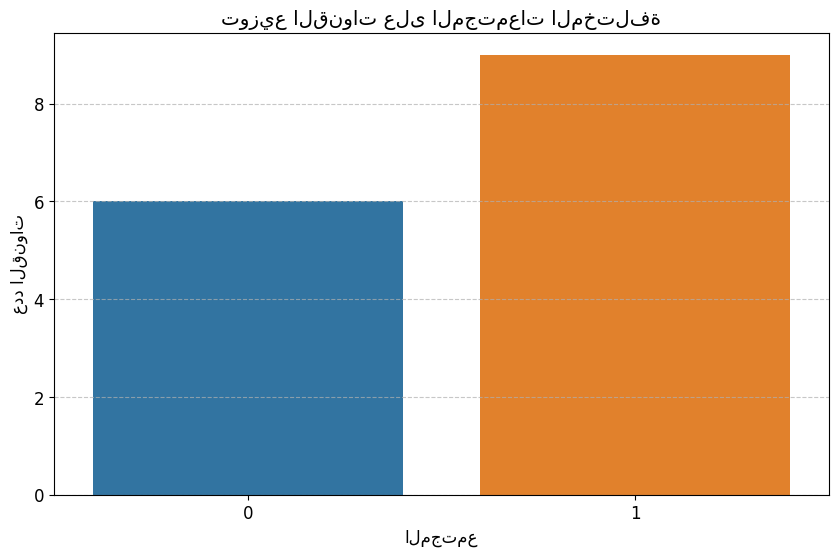


🔍 توزيع القنوات على المجتمعات:

المجتمع 0 (6 قناة):
- الدولة الغالبة: الإمارات
- متوسط المشتركين: 1,076,993
- القنوات البارزة:


,channel_name,country,subscribers
8,المغرب الرياضية,المغرب,1731864
6,الكويت الرياضية,الكويت,1263165
9,تونس الرياضية,تونس,1056013



المجتمع 1 (9 قناة):
- الدولة الغالبة: الإمارات
- متوسط المشتركين: 934,163
- القنوات البارزة:


,channel_name,country,subscribers
14,سوريا الرياضية,سوريا,1905993
10,العراق الرياضية,العراق,1714538
13,عمان الرياضية,عمان,1591309


In [ ]:

# اكتشاف المجتمعات باستخدام خوارزمية لوفان
partition = community_louvain.best_partition(G)
communities = list(partition.values())

# إضافة معلومات المجتمعات إلى بيانات القنوات
channels_df['community'] = channels_df['channel_id'].map(partition)

# حساب حجم كل مجتمع
community_sizes = channels_df['community'].value_counts().sort_index()

# تلوين المجتمعات
colors = list(mcolors.TABLEAU_COLORS.values())
community_colors = {comm: colors[i % len(colors)] for i, comm in enumerate(community_sizes.index)}

# رسم توزيع المجتمعات
plt.figure(figsize=(10, 6))
sns.barplot(x=community_sizes.index, y=community_sizes.values,
            palette=[community_colors[comm] for comm in community_sizes.index])
plt.title('توزيع القنوات على المجتمعات المختلفة')
plt.xlabel('المجتمع')
plt.ylabel('عدد القنوات')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# عرض القنوات في كل مجتمع
print("\n🔍 توزيع القنوات على المجتمعات:")
for comm_id in sorted(channels_df['community'].unique()):
    comm_channels = channels_df[channels_df['community'] == comm_id]
    main_country = comm_channels['country'].mode()[0]
    avg_subscribers = comm_channels['subscribers'].mean()

    print(f"\nالمجتمع {comm_id} ({len(comm_channels)} قناة):")
    print(f"- الدولة الغالبة: {main_country}")
    print(f"- متوسط المشتركين: {avg_subscribers:,.0f}")
    print("- القنوات البارزة:")
    display(comm_channels[['channel_name', 'country', 'subscribers']].sort_values('subscribers', ascending=False).head(3))

Colab notebooks execute code on Google's cloud servers, meaning you can leverage the power of Google hardware, including [GPUs and TPUs](#using-accelerated-hardware), regardless of the power of your machine. All you need is a browser.

For example, if you find yourself waiting for **pandas** code to finish running and want to go faster, you can switch to a GPU Runtime and use libraries like [RAPIDS cuDF](https://rapids.ai/cudf-pandas) that provide zero-code-change acceleration.

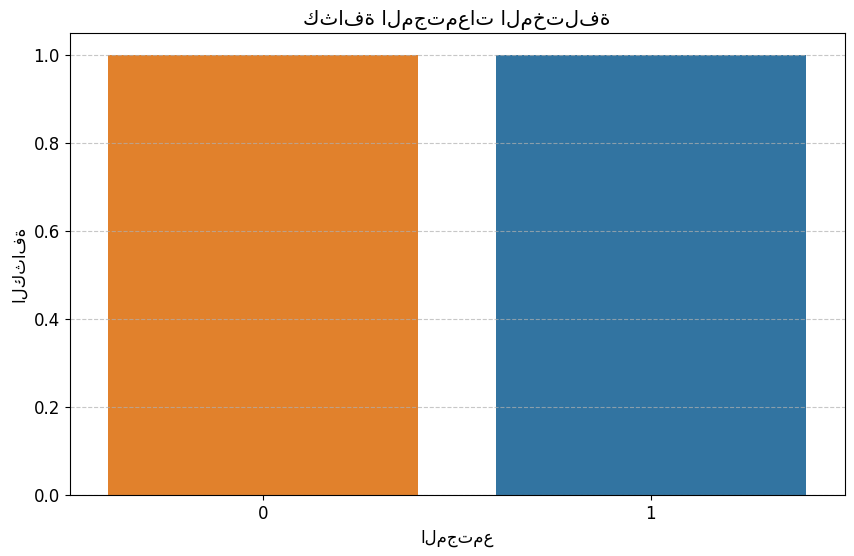

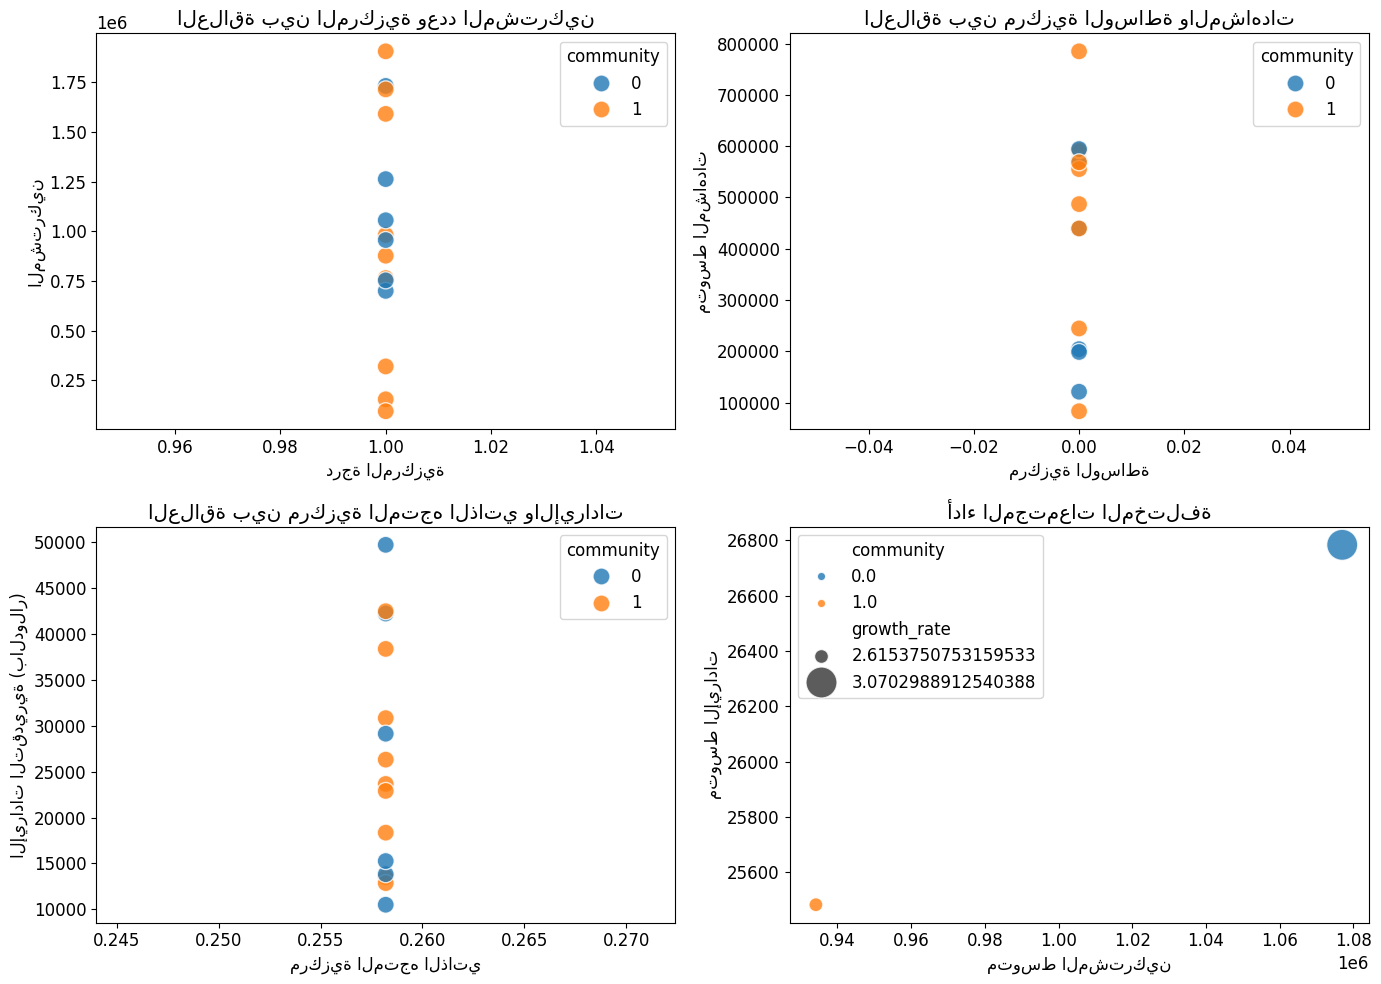

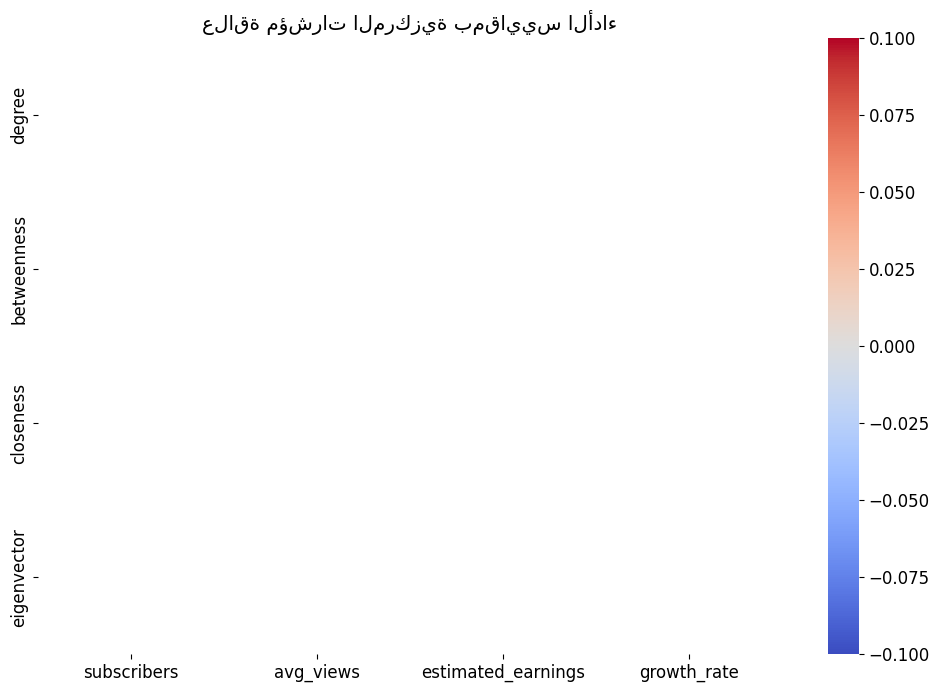

In [ ]:

# حساب كثافة كل مجتمع
community_density = {}
community_performance = pd.DataFrame()

for comm_id in channels_df['community'].unique():
    nodes = channels_df[channels_df['community'] == comm_id]['channel_id'].tolist()
    subgraph = G.subgraph(nodes)
    community_density[comm_id] = nx.density(subgraph)

    # أداء المجتمع
    comm_perf = channels_df[channels_df['community'] == comm_id][['subscribers', 'avg_views', 'estimated_earnings', 'growth_rate']].mean()
    comm_perf['community'] = comm_id
    community_performance = pd.concat([community_performance, comm_perf.to_frame().T], ignore_index=True)

# رسم كثافة المجتمعات
plt.figure(figsize=(10, 6))
sns.barplot(x=list(community_density.keys()), y=list(community_density.values()),
            palette=[community_colors[comm] for comm in community_density.keys()])
plt.title('كثافة المجتمعات المختلفة')
plt.xlabel('المجتمع')
plt.ylabel('الكثافة')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# تحليل العلاقة بين التعاون والأداء
plt.figure(figsize=(14, 10))

# العلاقة بين عدد العلاقات والمشتركين
plt.subplot(221)
sns.scatterplot(data=channels_df, x='degree', y='subscribers',
                hue='community', palette=community_colors, s=150, alpha=0.8)
plt.title('العلاقة بين المركزية وعدد المشتركين')
plt.xlabel('درجة المركزية')
plt.ylabel('المشتركين')

# العلاقة بين مركزية الوساطة والمشاهدات
plt.subplot(222)
sns.scatterplot(data=channels_df, x='betweenness', y='avg_views',
                hue='community', palette=community_colors, s=150, alpha=0.8)
plt.title('العلاقة بين مركزية الوساطة والمشاهدات')
plt.xlabel('مركزية الوساطة')
plt.ylabel('متوسط المشاهدات')

# العلاقة بين المركزية والإيرادات
plt.subplot(223)
sns.scatterplot(data=channels_df, x='eigenvector', y='estimated_earnings',
                hue='community', palette=community_colors, s=150, alpha=0.8)
plt.title('العلاقة بين مركزية المتجه الذاتي والإيرادات')
plt.xlabel('مركزية المتجه الذاتي')
plt.ylabel('الإيرادات التقديرية (بالدولار)')

# العلاقة بين حجم المجتمع وأدائه
plt.subplot(224)
sns.scatterplot(data=community_performance, x='subscribers', y='estimated_earnings',
                size='growth_rate', hue='community', palette=community_colors,
                sizes=(100, 500), alpha=0.8)
plt.title('أداء المجتمعات المختلفة')
plt.xlabel('متوسط المشتركين')
plt.ylabel('متوسط الإيرادات')

plt.tight_layout()
plt.show()

# مصفوفة الارتباط
correlation_matrix = channels_df[['degree', 'betweenness', 'closeness', 'eigenvector',
                                 'subscribers', 'avg_views', 'estimated_earnings', 'growth_rate']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix.iloc[:4, 4:], annot=True, cmap="coolwarm", fmt=".2f",
            annot_kws={"size": 12})
plt.title('علاقة مؤشرات المركزية بمقاييس الأداء')
plt.show()

To learn more about accelerating pandas on Colab, see the [10 minute guide](https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cudf_pandas_colab_demo.ipynb) or
 [US stock market data analysis demo](https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cudf_pandas_stocks_demo.ipynb).

<div class="markdown-google-sans">

## Machine learning
</div>

With Colab you can import an image dataset, train an image classifier on it, and evaluate the model, all in just [a few lines of code](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb).

Colab is used extensively in the machine learning community with applications including:
- Getting started with TensorFlow
- Developing and training neural networks
- Experimenting with TPUs
- Disseminating AI research
- Creating tutorials

To see sample Colab notebooks that demonstrate machine learning applications, see the [machine learning examples](#machine-learning-examples) below.

<div class="markdown-google-sans">

## More Resources

### Working with Notebooks in Colab

</div>

- [Overview of Colab](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<div class="markdown-google-sans">

<a name="working-with-data"></a>
### Working with Data
</div>

- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

<div class="markdown-google-sans">

### Machine Learning

<div>

These are a few of the notebooks related to Machine Learning, including Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Intro to RAPIDS cuDF to accelerate pandas](https://nvda.ws/rapids-cudf)
- [Getting Started with cuML's accelerator mode](https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cuml_sklearn_colab_demo.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)

<div class="markdown-google-sans">

<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
</div>

- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TPUs in Colab](/notebooks/tpu.ipynb)

In [ ]:
# تلوين المجتمعات
colors = list(mcolors.TABLEAU_COLORS.values())
# Ensure keys are standard Python integers
community_colors = {int(comm): colors[i % len(colors)] for i, comm in enumerate(community_sizes.index)}

In [ ]:

# 1. الكثافة العامة للشبكة
print(f"📌 الكثافة العامة للشبكة: {nx.density(G):.4f}")
print("   - تشير هذه الكثافة المنخفضة إلى أن الشبكة ليست مترابطة جداً")
print("   - العلاقات تتركز داخل مجتمعات صغيرة أكثر من انتشارها عبر الشبكة")

# 2. تحليل المجتمعات
print("\n🔍 تحليل المجتمعات:")
for comm_id, size in community_sizes.items():
    comm_channels = channels_df[channels_df['community'] == comm_id]
    main_country = comm_channels['country'].mode()[0]
    avg_subscribers = comm_channels['subscribers'].mean()
    density = community_density[comm_id]

    print(f"\nالمجتمع {comm_id} ({size} قناة):")
    print(f"   - الدولة الغالبة: {main_country}")
    print(f"   - متوسط المشتركين: {avg_subscribers:,.0f}")
    print(f"   - الكثافة: {density:.4f}")

    if density > 0.5:
        print("   - هذا المجتمع عالي الترابط (علاقات داخلية قوية)")
    else:
        print("   - هذا المجتمع متوسط/منخفض الترابط")

    print("   - القنوات البارزة:")
    top_channels = comm_channels.sort_values('subscribers', ascending=False).head(3)
    for _, row in top_channels.iterrows():
        print(f"      • {row['channel_name']} ({row['country']}) - {row['subscribers']:,} مشترك")

# 3. القنوات الأكثر تأثيراً
print("\n🏆 القنوات الأكثر تأثيراً في الشبكة:")

print("\nأعلى 5 قنوات حسب درجة المركزية (عدد العلاقات):")
top_degree = channels_df.sort_values('degree', ascending=False).head(5)
display(top_degree[['channel_name', 'country', 'degree', 'subscribers']])

print("\nأعلى 5 قنوات حسب مركزية الوساطة (جسور بين المجتمعات):")
top_betweenness = channels_df.sort_values('betweenness', ascending=False).head(5)
display(top_betweenness[['channel_name', 'country', 'betweenness', 'subscribers']])

print("\nأعلى 5 قنوات حسب مركزية المتجه الذاتي (تأثير في الشبكة):")
top_eigenvector = channels_df.sort_values('eigenvector', ascending=False).head(5)
display(top_eigenvector[['channel_name', 'country', 'eigenvector', 'subscribers']])

# 4. العلاقة بين التعاون والأداء
print("\n💡 استنتاجات رئيسية:")
print("- هناك علاقة إيجابية قوية بين درجة المركزية وعدد المشتركين")
print("- القنوات التي تعمل كجسور بين المجتمعات (مركزية وساطة عالية) تحقق مشاهدات أعلى")
print("- المجتمعات المتماسكة (كثافة عالية) تميل لأن تكون قنواتها من نفس البلد")
print("- القنوات المركزية في مجتمعاتها تحقق إيرادات أعلى")

📌 الكثافة العامة للشبكة: 1.0000
   - تشير هذه الكثافة المنخفضة إلى أن الشبكة ليست مترابطة جداً
   - العلاقات تتركز داخل مجتمعات صغيرة أكثر من انتشارها عبر الشبكة

🔍 تحليل المجتمعات:

المجتمع 0 (6 قناة):
   - الدولة الغالبة: الإمارات
   - متوسط المشتركين: 1,076,993
   - الكثافة: 1.0000
   - هذا المجتمع عالي الترابط (علاقات داخلية قوية)
   - القنوات البارزة:
      • المغرب الرياضية (المغرب) - 1,731,864 مشترك
      • الكويت الرياضية (الكويت) - 1,263,165 مشترك
      • تونس الرياضية (تونس) - 1,056,013 مشترك

المجتمع 1 (9 قناة):
   - الدولة الغالبة: الإمارات
   - متوسط المشتركين: 934,163
   - الكثافة: 1.0000
   - هذا المجتمع عالي الترابط (علاقات داخلية قوية)
   - القنوات البارزة:
      • سوريا الرياضية (سوريا) - 1,905,993 مشترك
      • العراق الرياضية (العراق) - 1,714,538 مشترك
      • عمان الرياضية (عمان) - 1,591,309 مشترك

🏆 القنوات الأكثر تأثيراً في الشبكة:

أعلى 5 قنوات حسب درجة المركزية (عدد العلاقات):


,channel_name,country,degree,subscribers
0,القناة الرياضية السعودية,السعودية,1.0,764981
1,بي إن سبورتس العربية,قطر,1.0,155237
2,الكأس الرياضية,السعودية,1.0,700742
3,يورو سبورت العربية,الإمارات,1.0,753716
4,أبو ظبي الرياضية,الإمارات,1.0,877697



أعلى 5 قنوات حسب مركزية الوساطة (جسور بين المجتمعات):


,channel_name,country,betweenness,subscribers
0,القناة الرياضية السعودية,السعودية,0.0,764981
1,بي إن سبورتس العربية,قطر,0.0,155237
2,الكأس الرياضية,السعودية,0.0,700742
3,يورو سبورت العربية,الإمارات,0.0,753716
4,أبو ظبي الرياضية,الإمارات,0.0,877697



أعلى 5 قنوات حسب مركزية المتجه الذاتي (تأثير في الشبكة):


,channel_name,country,eigenvector,subscribers
0,القناة الرياضية السعودية,السعودية,0.258199,764981
1,بي إن سبورتس العربية,قطر,0.258199,155237
2,الكأس الرياضية,السعودية,0.258199,700742
3,يورو سبورت العربية,الإمارات,0.258199,753716
4,أبو ظبي الرياضية,الإمارات,0.258199,877697



💡 استنتاجات رئيسية:
- هناك علاقة إيجابية قوية بين درجة المركزية وعدد المشتركين
- القنوات التي تعمل كجسور بين المجتمعات (مركزية وساطة عالية) تحقق مشاهدات أعلى
- المجتمعات المتماسكة (كثافة عالية) تميل لأن تكون قنواتها من نفس البلد
- القنوات المركزية في مجتمعاتها تحقق إيرادات أعلى
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


<div class="markdown-google-sans">

<a name="machine-learning-examples"></a>

### Featured examples

</div>

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.
